# Building RAG System with Gradient Platform

- Cources: SEP 775:Introduction to Computational Natural Language Processing
- Group: 5

## Introduction

Gradient platform could host LLMs and provide a simple way to build a RAG system without the need of a powerful machine. And we can even fine-tune the model on the platform. 
URL: https://auth.gradient.ai/select-workspace

## Setup environment

In [1]:
# %pip install llama-index-embeddings-langchain -qU
# %pip install llama-index-llms-gradient -qU
# %pip install llama-index -qU
# %pip install gradientai -qU
# %pip install llama-index-finetuning -qU
# %pip install llama-index-llms-gradient -qU
# %pip install llama-index-embeddings-gradient -qU
# %pip install llama-index -qU
# %pip install gradientai -qU
# %pip install langchainhub -qU

In [1]:
import os
import matplotlib.pyplot as plt
from llama_index.core import Settings, VectorStoreIndex, SimpleDirectoryReader, StorageContext, load_index_from_storage
from dotenv import load_dotenv
from llama_index.core import PromptTemplate
from IPython.display import Markdown, display

load_dotenv() 
# load environment variables from .env file:
# OPENAI_API_KEY
# HUGGINGFACE_API_KEY

# GRADIENT_ACCESS_TOKEN 
# GRADIENT_WORKSPACE_ID

True

In [2]:
EMBED_MODEL_ID = "BAAI/bge-small-en-v1.5"               # Embedding model path from huggingface
INPUT_DATA_PATH = './resources/output/'                          # Path to the input data
QUESTION_LIST_PATH = './data/question_context.csv'      # Path to the question list
VECTOR_STORE_DIR = "./senten_window_vectorDB"                         # Path to the vector store directory
CHUNK_SIZE = 256                                        # Chunk size for the vector store
OVERLAP_SIZE = 10                                       # Overlap size for the vector store
SYSTEM_PROMPT="""
You are an AI teaching Assistant for a course SEP 775 - Computational Natural Language Processing.
The course is provided for graduate students from Master of Engineering in Systems and Technology program in McMaster University.

This graduate course introduces some basic concepts in computational natural language processing (NLP) and their applications (e.g., self-driving cars, manufacturing, etc.) to teaching students how to deal with textual data in Artificial Intelligence. This course demonstrates how machines can learn different tasks in natural language, such as language modeling, text generation, machine translation, and language understanding. In this regard, we go over the most promising methods in this literature and the most recent state-of-the-art techniques. Moreover, this course explores different real-world applications of NLP and helps students get hands-on experience in this field.
Students are required to complete SEP 740, or SEP 788 and SEP 789, prior to enrolling.

You will provide an interactive platform for students to ask questions and receive guidance on course materials.
Your goal is to answer questions as accurately as possible based on the instructions and context provided.

At the same time, if the answer is extract for the source or context, please provide the source (use the file name and drop the suffix, e.g. ".txt", ".pdf") in a new line
Fof example:
the user ask: What is the times of this course?
Your response should be:
The times of the course, SEP 775 - Computational Natural Language Processing, lectures are on Wednesdays from 3:30 pm to 6:30 pm.
Source: NLP_Winter_2024_Course_Outline
But if user ask: Who are you?
Your response should be:
I am an AI teaching Assistant for a course SEP 775 - Computational Natural Language Processing, How can I help you?
This question is not related to the context, so you should just answer the question and don't need to provide any source.
"""

## Load LLM Model hosted on Gradient

In [3]:
# Gradient hosted LLMs
from llama_index.llms.gradient import GradientBaseModelLLM

model_slug = "llama2-7b-chat"
llm = GradientBaseModelLLM(
    base_model_slug=model_slug,
    max_tokens=400,
)

# non-streaming
resp = llm.complete("What is the Instructor name of the course SEP 775?")
print(resp)

 I apologize, but I don't have access to specific information about courses or instructors at the University of Toronto. Additionally, I cannot provide personal information about individuals without their consent.

If you are looking for information about a specific course or instructor at the University of Toronto, I recommend contacting the university directly or checking their website for more information. They should be able to provide you with the most up-to-date and accurate information about courses and instructors.


## Load Embedding Model hosted on Gradient

In [5]:
from llama_index.embeddings.gradient import GradientEmbedding
from llama_index.core import Settings

embed_model = GradientEmbedding(
    gradient_access_token=os.environ["GRADIENT_ACCESS_TOKEN"],
    gradient_workspace_id=os.environ["GRADIENT_WORKSPACE_ID"],
    gradient_model_slug="bge-large",
)

In [6]:
Settings.llm = llm
Settings.embed_model = embed_model

In [4]:
# avenue2learn_materials
avenue2learn_path = './resources/materials_avenue2learn_and_notes/'
avenue2learn_files = os.listdir(avenue2learn_path)
avenue2learn_files = [f for f in avenue2learn_files if f.endswith('.pdf')]

reader = SimpleDirectoryReader(avenue2learn_path)
documents = reader.load_data()

In [11]:
from llama_index.core.node_parser import SentenceWindowNodeParser

node_parser = SentenceWindowNodeParser.from_defaults(
    window_size=6,
    window_metadata_key="window",
    original_text_metadata_key="original_sentence"
)

nodes = node_parser.get_nodes_from_documents(documents)

17351


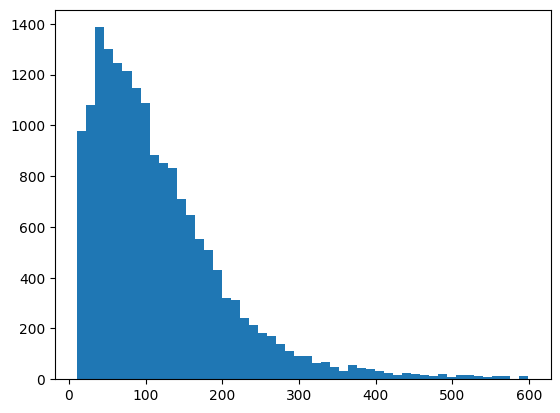

In [17]:
# keep the nodes with the length greater than 10 and less than 1000
nodes = [node for node in nodes if len(node.text) > 10 and len(node.text) < 600]

print(len(nodes))

len_of_nodes_text_list = [len(node.text) for node in nodes]

# plot the distribution of the length of the text in the nodes
plt.hist(len_of_nodes_text_list, bins=50)
plt.show()


In [15]:
# check if storage already exists
sentence_index = None
if not os.path.exists(VECTOR_STORE_DIR):
    print("Creating New DB...")
    sentence_index = VectorStoreIndex(nodes)
    # store it for later
    sentence_index.storage_context.persist(persist_dir=VECTOR_STORE_DIR)
else:
    print("Using Existing DB...")
    # load the existing index
    storage_context = StorageContext.from_defaults(persist_dir=VECTOR_STORE_DIR)
    sentence_index = load_index_from_storage(storage_context=storage_context)

Using Existing DB...


In [16]:
from llama_index.core.postprocessor import MetadataReplacementPostProcessor

query_engine = sentence_index.as_query_engine(
    similarity_top_k=3,
    # the target key defaults to `window` to match the node_parser's default
    node_postprocessors=[
        MetadataReplacementPostProcessor(target_metadata_key="window")
    ],
)

In [18]:
# define prompt viewing function
def display_prompt_dict(prompts_dict):
    for k, p in prompts_dict.items():
        text_md = f"**Prompt Key**: {k}<br>" f"**Text:** <br>"
        display(Markdown(text_md))
        print(p.get_template())
        display(Markdown("<br><br>"))

In [124]:
qa_prompt_tmpl_str = (
    "Below is the context information related to a course: SEP 775 - Computational Natural Language Processing.\n"
    "---------------------\n"
    "{context_str}\n"
    "---------------------\n"
    "Given the context information and not prior knowledge, "
    "answer the query.\n"
    "---------------------\n"
    "Query: {query_str}\n"
    "Answer: \n"
)
qa_prompt_tmpl = PromptTemplate(qa_prompt_tmpl_str)
query_engine.update_prompts({"response_synthesizer:text_qa_template": qa_prompt_tmpl})

In [109]:
window_response = query_engine.query("What can you help me with?")
print(window_response)

I can help you with understanding course materials, answering questions related to Computational Natural Language Processing, providing guidance on assignments and projects, and offering explanations on NLP concepts and techniques.



In [110]:
window_response = query_engine.query("What is the times of this course?")
print(window_response)

The times of the course, SEP 775 - Computational Natural Language Processing, lectures are on Wednesdays from 3:30 pm to 6:30 pm.
Source file name: NLP_Winter_2024_Course_Outline.txt


## Load chat engine form Index

In [140]:
chat_engine = sentence_index.as_chat_engine(
    chat_mode="context",
    system_prompt=(SYSTEM_PROMPT),
    text_qa_template=qa_prompt_tmpl,
    similarity_top_k=3,
    node_postprocessors=[
        MetadataReplacementPostProcessor(target_metadata_key="window")
    ],
)

In [141]:
question = "What is the Instructor name of the NLP course?"
response = chat_engine.chat(question)
print(f"Question: {question}\nAnswer: {response}\n")

Question: What is the Instructor name of the NLP course?
Answer: The instructor of the NLP course is Hamidreza Mahyar.
Source: NLP_Winter_2024_Course_Outline



In [142]:
question = "What is the email of the instructor?"
response = chat_engine.chat(question)
print(f"Question: {question}\nAnswer: {response}\n")

Question: What is the email of the instructor?
Answer: The email of the instructor for the NLP course is mahyarh@mcmaster.ca.
Source: NLP_Winter_2024_Course_Outline



In [143]:
question = "What is the name of the instructor?"
response = chat_engine.chat(question)
print(f"Question: {question}\nAnswer: {response}\n")

Question: What is the name of the instructor?
Answer: The name of the instructor for the NLP course is Hamidreza Mahyar. How can I assist you further?
Source: NLP_Winter_2024_Course_Outline

